In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import scienceplots
from cmcrameri import cm

In [3]:
plt.style.use(['science', 'grid'])

In [4]:
df = pd.read_csv("data.csv")
# Ensure we are testing diffraction pattern data
df = df.loc[df.seed.str.match('^pattern.*')]
# Filter out train data
df = df.loc[df.phase.str.match('(test|val)')]
# Use epoch 100
df = df.loc[df.epoch == 100]
# Use numbers to take average
df_num = df.select_dtypes(include="number")
df_num = df_num.groupby('code').mean().reset_index()

space_groups = pd.read_csv("space_groups.csv", index_col="ICSD_code").to_dict()["space_group"]

In [5]:
print(df_num)

         code          index  epoch       MSE
0          16   93606.000000  100.0  0.016485
1          25  181147.000000  100.0  0.000903
2          93  309429.000000  100.0  0.016277
3         119  307235.666667  100.0  0.009749
4         121  121462.000000  100.0  0.010298
...       ...            ...    ...       ...
11059  759462  351820.000000  100.0  0.002744
11060  759650  374635.000000  100.0  0.000084
11061  759651  371525.000000  100.0  0.000379
11062  759652  464946.000000  100.0  0.001849
11063  760017  337285.500000  100.0  0.000332

[11064 rows x 4 columns]


In [9]:
groups = sorted(df.group.unique())
n = 21
groups_losses = {group: [0] * n for group in groups}
for index, row in df_num.iterrows():
    group = space_groups[int(row["code"])]
    RMSE = np.sqrt(row["MSE"])
    for i, e in enumerate(np.linspace(0, 1, n)):
        if RMSE <= e:
            groups_losses[group][i] += 1
            break

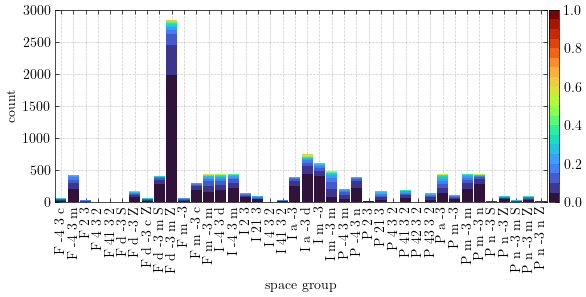

In [28]:

fig, ax = plt.subplots(figsize=(7.5, 2.5))
pparam = dict(xlabel=r'space group', ylabel=r'count', ylim=[0, 3000])

plt.xticks(rotation='vertical')
plt.minorticks_off()
plt.grid(alpha=0.2)
plt.margins(0, 0)

spaces = np.linspace(0, 1, n)
cmap = mpl.cm.turbo
colors = [cmap(i) for i in spaces]
bottom=np.zeros(len(groups))

for i in range(n):
    weights = [groups_losses[group][i] for group in groups]
    p = ax.bar(groups, weights, 0.9, bottom=bottom, color=colors[i-1])
    bottom += weights
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(spaces, cmap.N), cmap=cmap), ax=ax, pad=0.005, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set(**pparam)
fig.savefig('figures/space_group_losses', dpi=1200)